In [1]:
import os, sys
sys.path.append("../..")


In [2]:
import csv
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

from src.evolution.mutations import combined, mab, lin2opt, relocate_block, double_bridge, point_exchange
from src.evolution.run_evolution import run_evolution
from src.graph_utils.Graph import Graph, Mode
from src.visualization.draw_graph import draw_orders, draw_graph


In [3]:
# rewrite the statistics file

with open('../../data/convergence/statistics.csv', 'w') as f:
    writer = csv.writer(f)

    header = ['size', 'n_ep', 'pool','from_index', 'lo_progress', 'lo_time', 'lo_epochs', 'db_progress', 'db_time', 'db_epochs', 'pe_progress', 'pe_time', 'pe_epochs', 'rb_progress', 'rb_time', 'rb_epochs', 'cmb_progress', 'cmb_time', 'cmb_epochs', 'mab_progress', 'mab_time', 'mab_epochs', 'mab_lo_pulls', 'mab_db_pulls', 'mab_pe_pulls', 'mab_ce_pulls', 'mab_rb_pulls']

    writer.writerow(header)


In [4]:
def print_path(evolution, ax_hist, ax_result, mutation_str):
    hist = evolution.get_fitness_hist()
    ax_hist.scatter([i for i, _ in enumerate(hist)], hist)
    best_path = evolution.get_best_path()
    draw_graph(ax_result, best_path)

    ax_hist.set_title(f'{mutation_str} fitness hist')
    ax_result.set_title(f'{mutation_str} result')
    

In [5]:
def get_statistics(size, n_ep, pool, from_index=0):
    df = pd.read_csv('../../data/taxi/coordinates_by_id.csv', sep=',')
    
    with open('../../data/taxi_partly/coordinates_by_id.csv', 'w') as f:
        writer = csv.writer(f)
        header = ['coord_x', 'coord_y']
        writer.writerow(header)
        for key, row in tqdm(df.iterrows()):
            writer.writerow(row)

    df = pd.read_csv('../../data/taxi/orders.csv', sep=',')
    
    df = df.sample(frac=1)
    # .sample(frac=1, random_state=42)
    
    with open('../../data/taxi_partly/orders.csv', 'w') as f:
        writer = csv.writer(f)
        header = ['from', 'to']
        writer.writerow(header)
        for key, row in tqdm(df.iloc[from_index:from_index+size].iterrows()):
            writer.writerow(row)

    g = Graph(Mode.IDS, dataset_dir="../../data/taxi_partly")
    g.set_path_weight(g.get_path_weight())
    
    evolution_lo = run_evolution(n_epochs=n_ep, pool_size=pool, mutation=lin2opt, initial_graph=g)
    evolution_db = run_evolution(n_epochs=n_ep, pool_size=pool, mutation=double_bridge, initial_graph=g)
    evolution_pe = run_evolution(n_epochs=n_ep, pool_size=pool, mutation=point_exchange, initial_graph=g)
    evolution_rb = run_evolution(n_epochs=n_ep, pool_size=pool, mutation=relocate_block, initial_graph=g)
    evolution_cmb = run_evolution(n_epochs=n_ep, pool_size=pool, mutation=combined, initial_graph=g)
    evolution_mab = run_evolution(n_epochs=n_ep, pool_size=pool, mutation=mab, initial_graph=g)
    
    fig, ((ax00, ax10),
          (ax01, ax02),
          (ax11, ax12),
          (ax21, ax22),
          (ax31, ax32),
          (ax41, ax42),
          (ax51, ax52)) = plt.subplots(nrows=7, ncols=2, figsize=(10, 35))
    
    ax00.set_title('orders')
    draw_orders(ax00, dataset_dir='../../data/taxi_partly')
    ax10.set_title('start path')
    draw_graph(ax10, g)
    
    print_path(evolution_lo, ax01, ax02, 'lin2opt')
    print_path(evolution_db, ax11, ax12, 'double_bridge')
    print_path(evolution_pe, ax21, ax22, 'point_exchange')
    print_path(evolution_rb, ax31, ax32, 'relocate_block')
    print_path(evolution_cmb, ax41, ax42, 'combined')
    print_path(evolution_mab, ax51, ax52, 'bandit')
    
    with open('../../data/convergence/statistics.csv','a') as f:
        writer = csv.writer(f)
        row = [size, n_ep, pool, from_index,
               evolution_lo.progress, evolution_lo.time, evolution_lo.epochs,
               evolution_db.progress, evolution_db.time, evolution_db.epochs,
               evolution_pe.progress, evolution_pe.time, evolution_pe.epochs,
               evolution_rb.progress, evolution_rb.time, evolution_rb.epochs,
               evolution_cmb.progress, evolution_cmb.time, evolution_cmb.epochs,
               evolution_mab.progress, evolution_mab.time, evolution_mab.epochs,
               *evolution_mab.pulls]

        writer.writerow(row)


8130it [00:00, 27540.44it/s]
50it [00:00, 10410.80it/s]
99it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 368.35it/s]


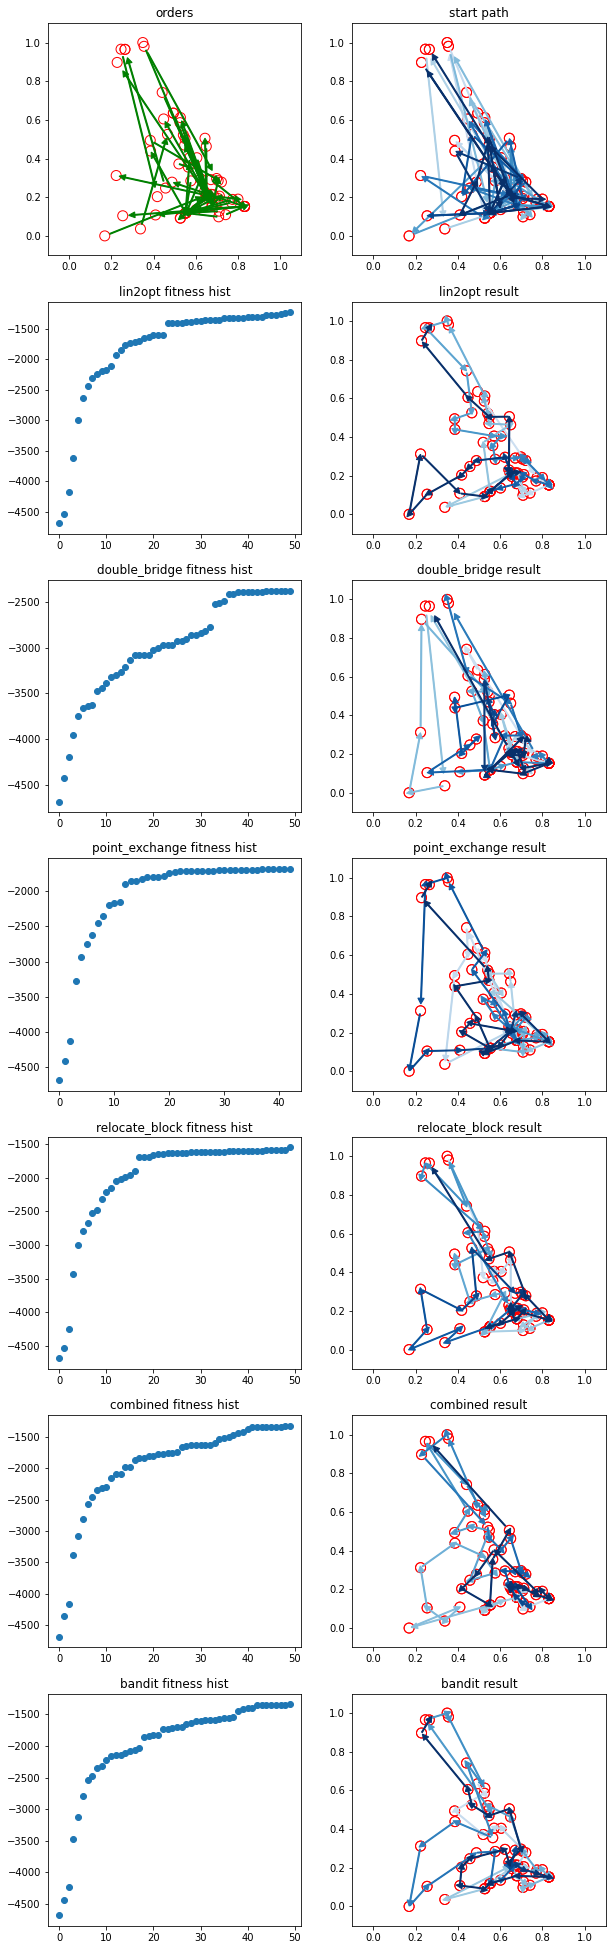

In [6]:
get_statistics(size=50, n_ep=50, pool=50, from_index = 0)


In [7]:
df = pd.read_csv('../../data/convergence/statistics.csv', sep=',')
(df.drop(['from_index'], axis=1)).head(10)

,size,n_ep,pool,lo_progress,lo_time,lo_epochs,db_progress,db_time,db_epochs,pe_progress,...,cmb_time,cmb_epochs,mab_progress,mab_time,mab_epochs,mab_lo_pulls,mab_db_pulls,mab_pe_pulls,mab_ce_pulls,mab_rb_pulls
0,50,50,50,73.81,0:00:03,50,49.27,0:00:03,50,64.05,...,0:00:07,50,71.38,0:00:04,50,290,8,31,1,16


In [8]:
(df.drop(['from_index'], axis=1))[['size', 'lo_progress', 'db_progress', 'pe_progress', 'rb_progress', 'cmb_progress', 'mab_progress']].head(10)

,size,lo_progress,db_progress,pe_progress,rb_progress,cmb_progress,mab_progress
0,50,73.81,49.27,64.05,66.81,71.63,71.38
